<a href="https://colab.research.google.com/github/SupidchayaTangkidwanich/Train_test_new/blob/main/Unfreeze_Train_id10_id12_id2_id6_Test_id8_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unfreeze

In [1]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  # คลิกที่ลิงก์ -> เลือก E-mail -> ลงชื่อเข้าใช้ -> ก็อปโค้ด -> นำกลับมาวางในช่องว่าง -> กด enter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls

drive/  efficientnet_keras_transfer_learning/  sample_data/


In [3]:
import pandas as pd

## import data

In [4]:
df = pd.read_csv (r'/content/drive/MyDrive/data/id8_test.csv')
df

,Unnamed: 0,Path_Name,id,Part
0,0,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
1,1,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
2,2,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
3,3,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
4,4,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
...,...,...,...,...
243523,243523,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243524,243524,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243525,243525,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243526,243526,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07


## Import tensorflow

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [6]:
batch_size = 20
width = 150
height = 150
epochs = 100
NUM_TRAIN = 100
NUM_TEST = 100
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone Efficientnet

In [7]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [8]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [9]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

## แบ่งข้อมูล Train & Test

In [11]:
DATA_PATH = "/content/drive/My Drive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/My Drive/id/train
/content/drive/My Drive/id/test


In [12]:
train = df[df['Unnamed: 0'].between(0,192443)]
test = df[df['Unnamed: 0'].between(192444,243527)]

## Train

In [13]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test,
        directory = test_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

Found 192444 validated image filenames belonging to 15 classes.
Found 51084 validated image filenames belonging to 15 classes.


In [15]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(15, activation='softmax', name="fc_out"))

In [16]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 15)                19215     
                                                                 
Total params: 4,068,779
Trainable params: 19,215
Non-trainable params: 4,049,564
_________________________________________________________________


## unfreeze

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_15':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers after freezing the conv base: 8


## Training

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-19-6ef5d1e0375e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
5/5 [==============================] - 43s 7s/step - loss: 7.0377 - acc: 0.2200 - val_loss: 3.3395 - val_acc: 0.3400
Epoch 2/100
5/5 [==============================] - 34s 7s/step - loss: 3.7825 - acc: 0.3600 - val_loss: 3.3942 - val_acc: 0.3000
Epoch 3/100
5/5 [==============================] - 33s 6s/step - loss: 3.7029 - acc: 0.3500 - val_loss: 3.0609 - val_acc: 0.3400
Epoch 4/100
5/5 [==============================] - 33s 7s/step - loss: 3.4562 - acc: 0.4200 - val_loss: 4.0103 - val_acc: 0.3200
Epoch 5/100
5/5 [==============================] - 32s 6s/step - loss: 2.4078 - acc: 0.5200 - val_loss: 5.0423 - val_acc: 0.3200
Epoch 6/100
5/5 [==============================] - 28s 5s/step - loss: 2.7170 - acc: 0.4600 - val_loss: 2.5006 - val_acc: 0.4100
Epoch 7/100
5/5 [==============================] - 33s 6s/step - loss: 2.5896 - acc: 0.5300 - val_loss: 4.1480 - val_acc: 0.2500
Epoch 8/100
5/5 [==============================] - 34s 7s/step - loss: 2.1753 - acc: 0.5100 - val

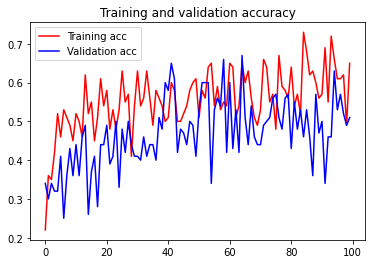

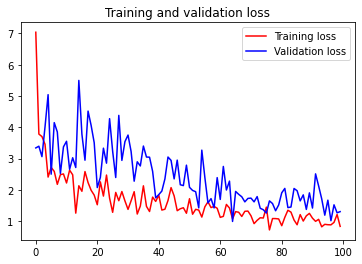

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## save model

In [21]:
os.makedirs('/content/drive/MyDrive/Model', exist_ok=True)
model.save('/content/drive/My Drive/Model/Unfreeze_Train_id10_id12_id2_id6_Test_id8_100.h5')

In [22]:
from google.colab import files